In [41]:
import numpy as np
import scipy.integrate as integrate
import scipy.fft as fft
import scipy.signal as signal
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [42]:
# Import data
# And yes, I did verify that this gets the data imported properly
in_data = pd.read_csv('NL_Dynamics_2500_Samples.csv', usecols = [1,2,3,4,5,6,7])
out_data = pd.read_csv('NL_Dynamics_2500_Samples.csv', usecols = np.arange(8,408))

In [43]:
# Build input layer and first hidden layer
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(14, input_shape = (7,), activation = 'swish'))

# Adding more hidden layers
model.add(tf.keras.layers.Dense(14, activation = 'swish'))
model.add(tf.keras.layers.Dense(63, activation = 'swish'))
model.add(tf.keras.layers.Dense(112, activation = 'swish'))
model.add(tf.keras.layers.Dense(161, activation = 'swish'))
model.add(tf.keras.layers.Dense(210, activation = 'swish'))
model.add(tf.keras.layers.Dense(259, activation = 'swish'))
model.add(tf.keras.layers.Dense(308, activation = 'swish'))
model.add(tf.keras.layers.Dense(357, activation = 'swish'))
model.add(tf.keras.layers.Dense(400, activation = 'swish'))

In [44]:
model.compile(loss = tf.keras.losses.MeanSquaredError(), optimizer = tf.keras.optimizers.Adam(), metrics = [tf.keras.metrics.MeanSquaredError()])

In [45]:
%%time

model.fit(in_data, out_data, epochs = 400, batch_size = 64, verbose = 0, validation_split = .25)

Wall time: 2min 26s


In [46]:
mse = model.evaluate(in_data, out_data, verbose=1)
# Note that this model was trained to recreate the data in the frequency domain

model.save('Chatter Research')

79/79 [==============================] - 1s 7ms/step - loss: 2.4310 - mean_squared_error: 2.4310


INFO:tensorflow:Assets written to: Chatter Research\assets


INFO:tensorflow:Assets written to: Chatter Research\assets


In [47]:
# This cell containts mostly copy/pasted code from the "Frequency Analysis" notebook

m = np.random.uniform(.1,.25) # mass, kg
c1 = np.random.uniform(.1,0.3) # damper attached to mass, Ns/m
k1 = np.random.uniform(10,100) # spring attached to mass, N/m
a = np.random.uniform(10,50) # force amplitude, N
w = np.random.uniform(1,20) # force frequency, rad/s
k2 = np.random.uniform(k1,4*k1) # second spring, N/m
d = np.random.uniform(0,a/k1) # distance from x=0 to the second spring, m

tlist = np.arange(0,10,.025)

def force(t): return a*np.sin(w*t)

def mysystem(x,t):
    dx1dt = x[1]
    dx2dt = (force(t) - c1*x[1] - np.heaviside(x[0]-d,1)*k2*(x[0]-d) - k1*x[0])/m
    dxdt = [dx1dt,dx2dt]
    return dxdt

x = integrate.odeint(func = mysystem,t = tlist,y0 = [0,0])

x1 = x[:,0]
x2 = x[:,1]

1/1 [==============================] - 0s 115ms/step


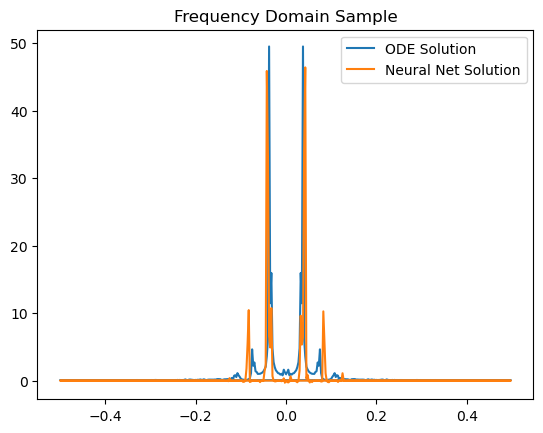

In [48]:
# Comparing frequency domain data

nn_fft = model.predict(np.array([m,c1,k1,a,w,k2,d]).reshape(1,7))
nn_fft = nn_fft[0]

velofft = fft.fft(x2)
N = np.size(velofft)
T = .025
xf = fft.fftfreq(len(tlist))
yf = 2/N * np.abs(velofft)
plt.plot(xf, yf)
plt.plot(xf,nn_fft)
plt.legend(['ODE Solution','Neural Net Solution'])
plt.title('Frequency Domain Sample')
plt.show()

c:\Users\benja\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


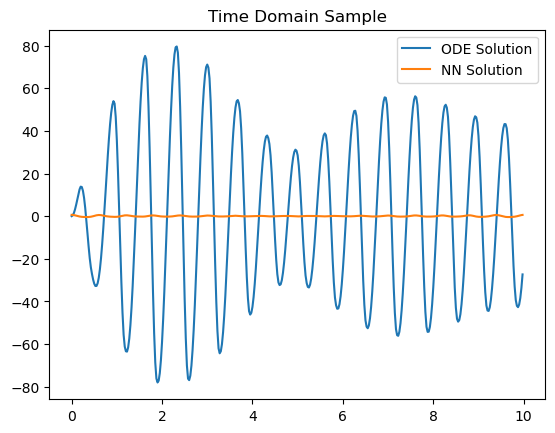

In [49]:
# Comparing time domain data
# (as recreated with an inverse Fourier transform for the neural net case)

nn_time = fft.ifft(nn_fft)
plt.plot(tlist,x2)
plt.plot(tlist,nn_time)
plt.legend(['ODE Solution','NN Solution'])
plt.title('Time Domain Sample')
plt.show()

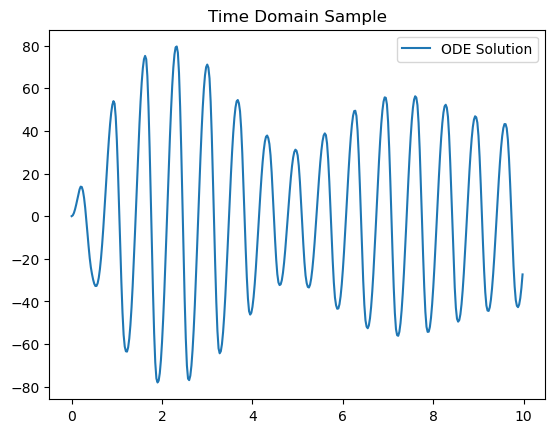

In [50]:
# Appending two zeroes on the end just so there's a graph to look at

nn_time = fft.ifft(nn_fft)

plt.plot(tlist,x2)
#plt.plot(tlist,nn_time)
plt.legend(['ODE Solution','NN Solution'])
plt.title('Time Domain Sample')
plt.show()

In [51]:
np.size(x2)

400